# Flight Price Prediction

In this notebook, we will consider the problem of modelling flight price predicition based on the data from Kaggle website.

## Import Necessary Libraries

First, we need to import the libraries that will be used throughout this notebook.

In [28]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate


## Load Datasets

Now, let's load the datasets that we will be using for our analysis.


In [29]:
# Load datasets
business_df = pd.read_csv('../datasets/business.csv')
economy_df = pd.read_csv('../datasets/economy.csv')
clean_dataset = pd.read_csv('../datasets/Clean_Dataset.csv')
business_df.head()
economy_df.head()
clean_dataset.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [30]:
clean_dataset.shape
clean_dataset.describe(include='all')

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153.000000,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,NaN,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,NaN,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,NaN,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,150076.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,86646.852011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,75038.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,150076.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,225114.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


In [31]:
clean_dataset.dropna(inplace=True)
clean_dataset.shape

(300153, 12)

In [32]:
clean_dataset.isnull().sum()

Unnamed: 0          0
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64


# Let's visualize the first few rows of the dataset

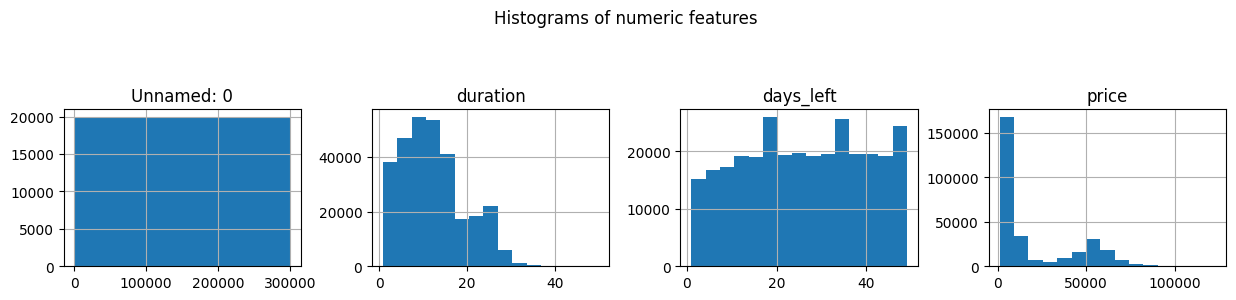

In [33]:
# Plotting histograms for all numeric features to understand distributions
clean_dataset.hist(bins=15, figsize=(15, 10), layout=(4, 4))
plt.suptitle('Histograms of numeric features')
plt.show()

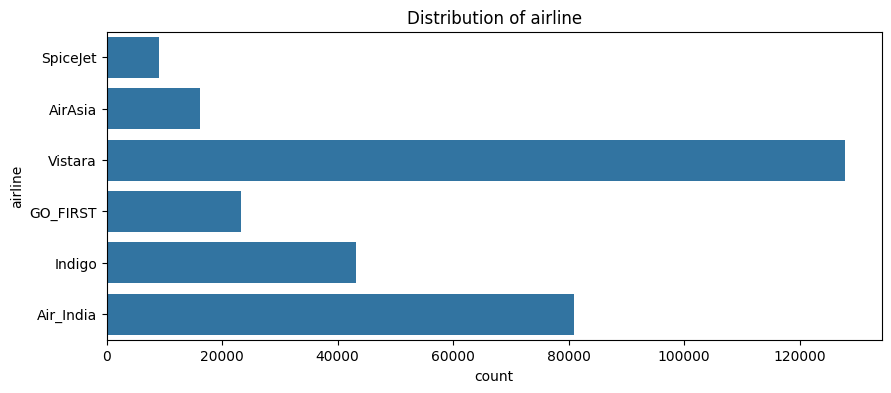

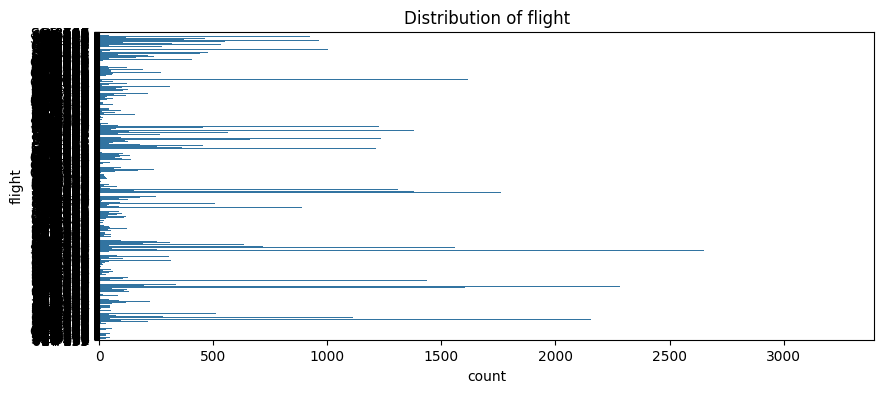

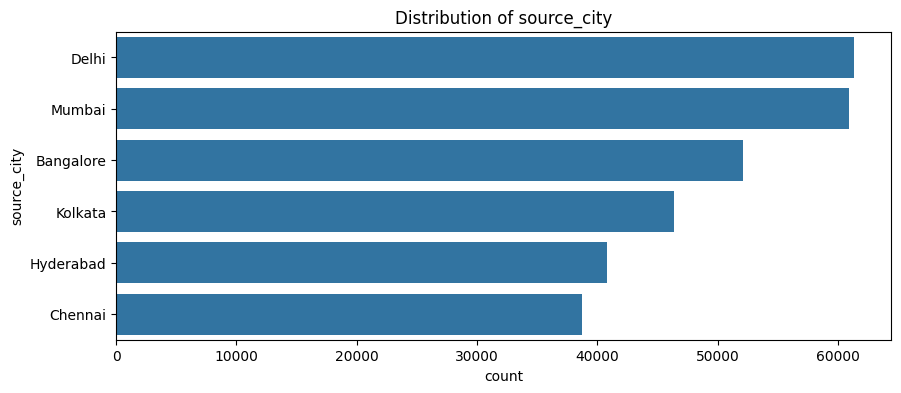

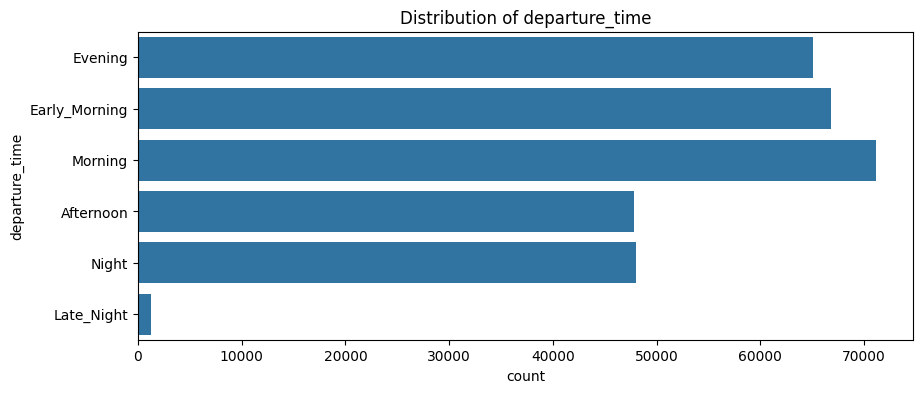

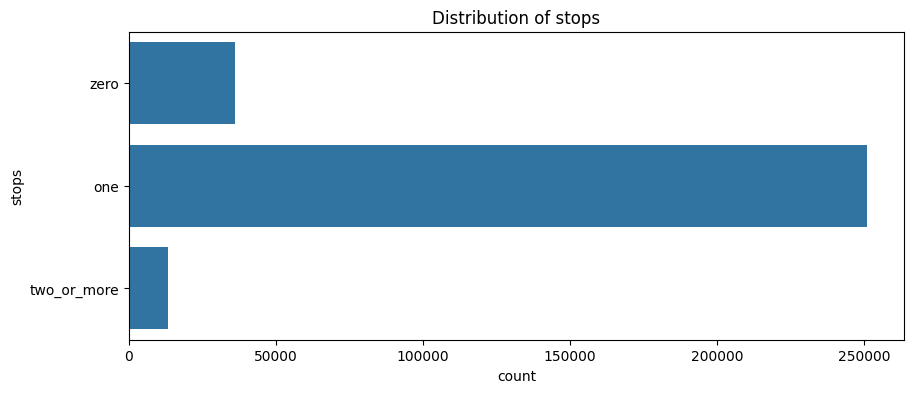

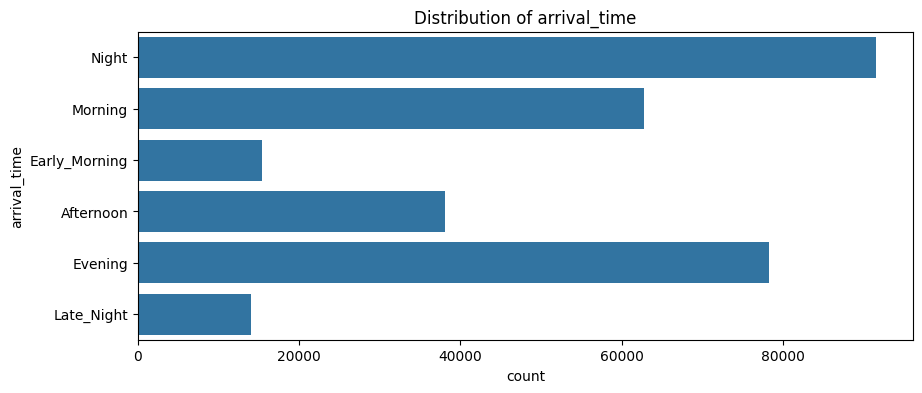

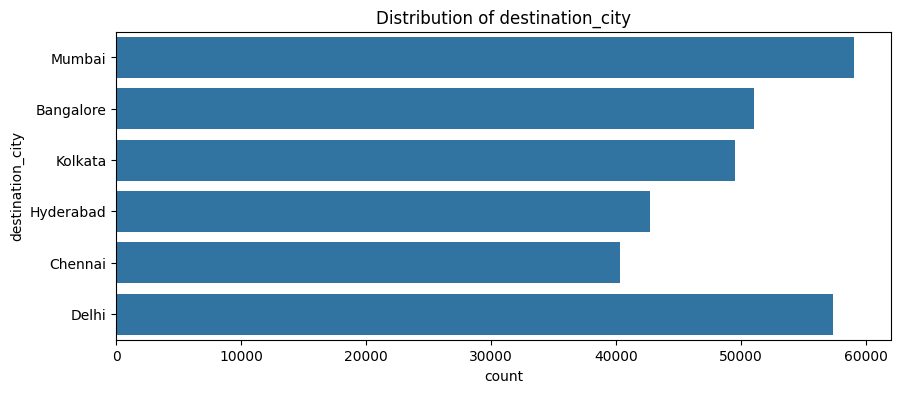

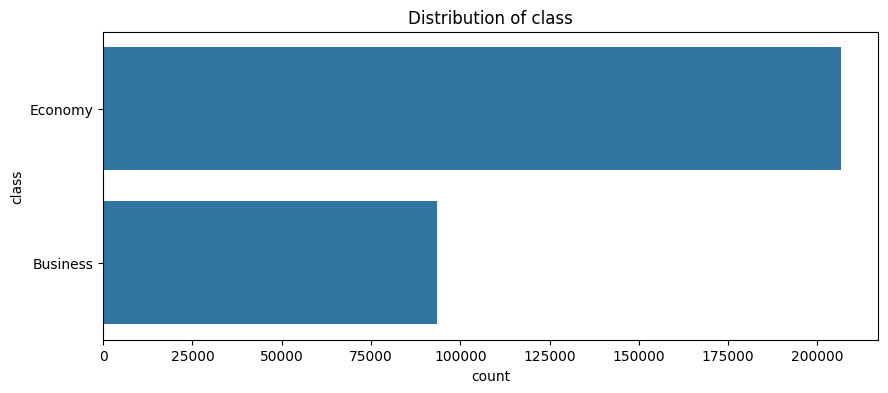

In [34]:
# For categorical data, we can use count plots to understand the distribution of categories
for column in clean_dataset.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(10, 4))
    sns.countplot(y=column, data=clean_dataset)
    plt.title(f'Distribution of {column}')
    plt.show()

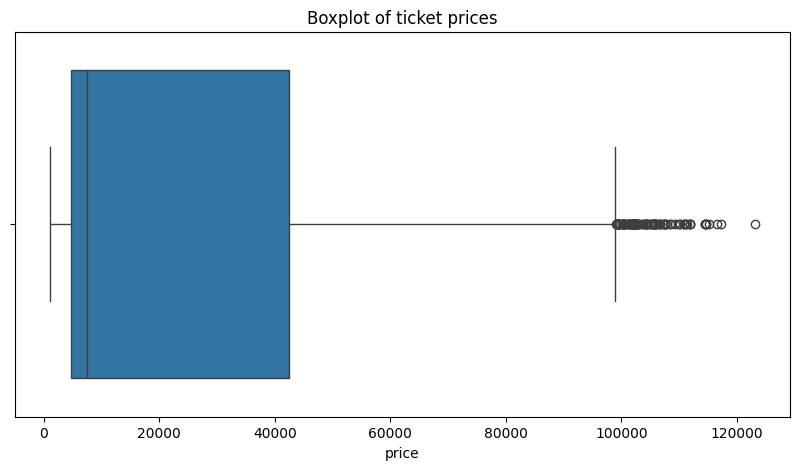

In [35]:
# Boxplot for the price column to see its distribution and spot any outliers
plt.figure(figsize=(10, 5))
sns.boxplot(x=clean_dataset['price'])
plt.title('Boxplot of ticket prices')
plt.show()

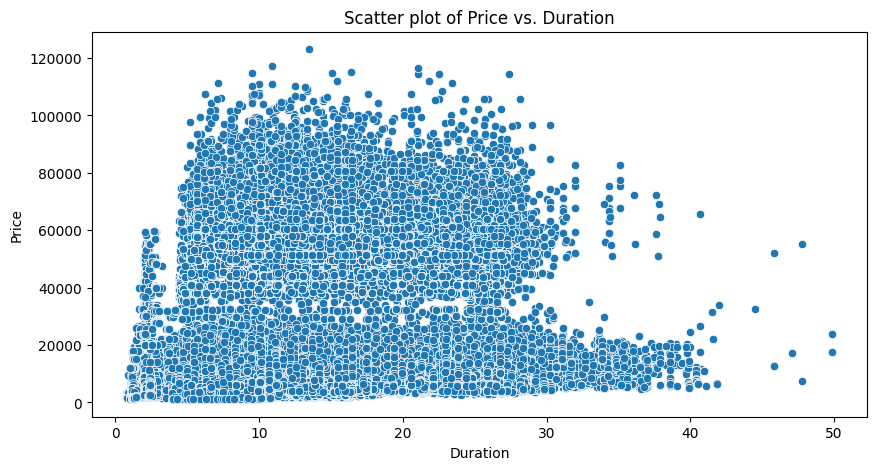

In [36]:
# A scatter plot to visualize the relationship between two variables, for example, price and duration
plt.figure(figsize=(10, 5))
sns.scatterplot(x=clean_dataset['duration'], y=clean_dataset['price'])
plt.title('Scatter plot of Price vs. Duration')
plt.xlabel('Duration')
plt.ylabel('Price')
plt.show()



In [37]:
# Correlation heatmap to understand the relationships between variables
# Select only the numeric columns for correlation
numeric_dataset = clean_dataset.select_dtypes(include=[np.number])
correlation_matrix = numeric_dataset.corr()

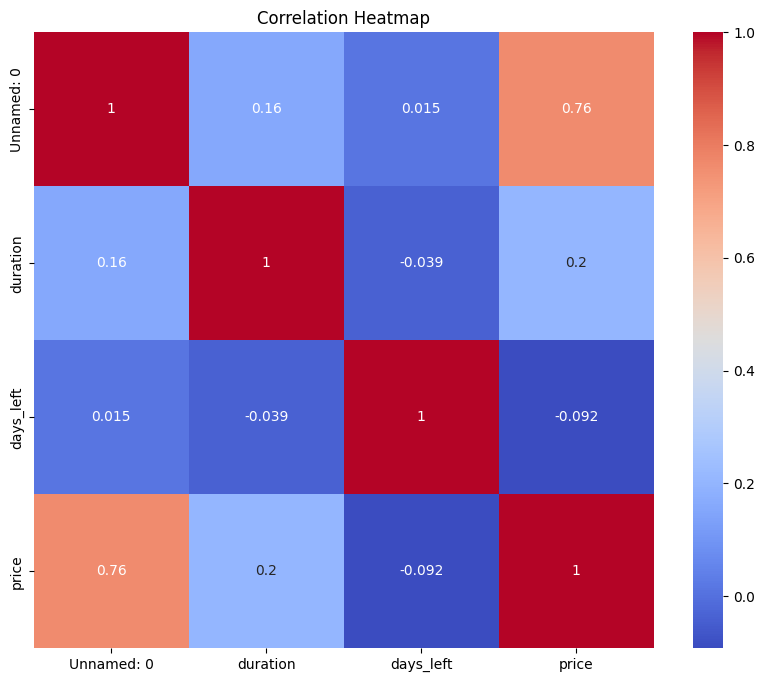

In [38]:
# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

<Axes: xlabel='price'>

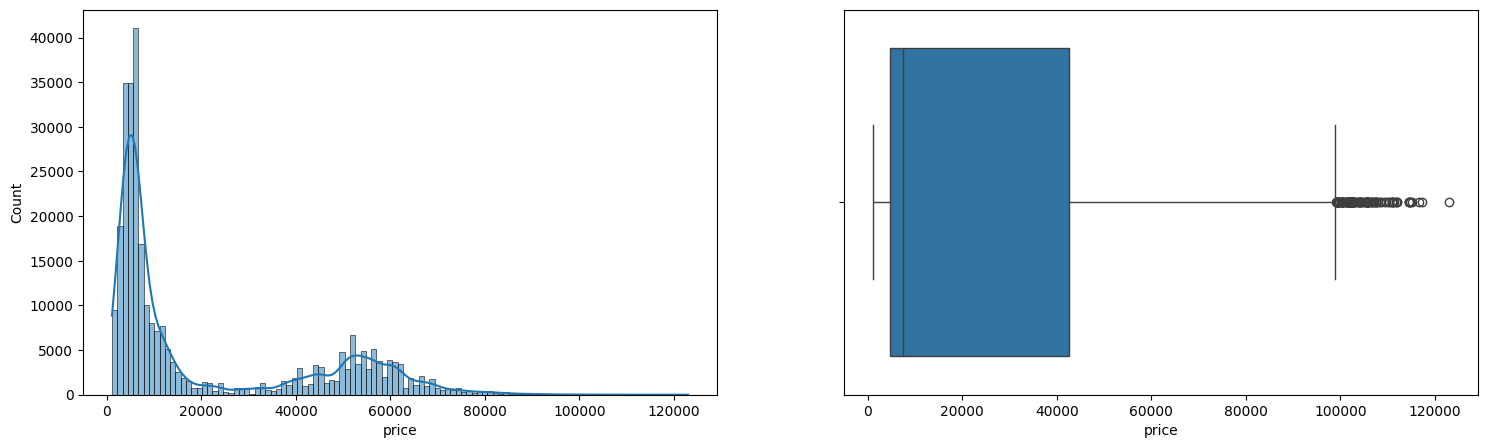

In [39]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.histplot(x = 'price', data = clean_dataset, kde = True)
plt.subplot(1,2,2)
sns.boxplot(x = 'price', data = clean_dataset)

# make data transformation

In [40]:
transformed_dataset = clean_dataset.copy()
transformed_dataset['Economy'] = clean_dataset['class'] == 'Economy'
transformed_dataset.drop('class', axis=1, inplace=True)

In [41]:
#transformed_dataset['source_city'].unique()

In [42]:
city_size = { # this is for year 2011 - https://en.wikipedia.org/wiki/List_of_cities_in_India_by_population
    'Delhi': 110,
    'Mumbai': 124,
    'Bangalore': 84,
    'Kolkata': 44,
    'Hyderabad': 69,
    'Chennai' : 46
}
transformed_dataset['source_size'] = transformed_dataset['source_city'].replace(city_size)
transformed_dataset.drop('source_city', axis=1, inplace=True)
transformed_dataset['destination_size'] = transformed_dataset['destination_city'].replace(city_size)
transformed_dataset.drop('destination_city', axis=1, inplace=True)

In [43]:
transformed_dataset = pd.get_dummies(transformed_dataset,columns=['departure_time','arrival_time'])

In [44]:
stops = {
    'zero': 0,
    'one': 1,
    'two_or_more': 2,
}
transformed_dataset['stops_num'] = transformed_dataset['stops'].replace(stops)
transformed_dataset.drop('stops', axis=1, inplace=True)

In [45]:
transformed_dataset = pd.get_dummies(transformed_dataset,columns=['airline'])

In [46]:
transformed_dataset['flight_num'] = pd.factorize(transformed_dataset['flight'])[0]
transformed_dataset.drop('flight', axis=1, inplace=True)

In [47]:
transformed_dataset.head()

,Unnamed: 0,duration,days_left,price,Economy,source_size,destination_size,departure_time_Afternoon,departure_time_Early_Morning,departure_time_Evening,...,arrival_time_Morning,arrival_time_Night,stops_num,airline_AirAsia,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,flight_num
0,0,2.17,1,5953,True,110,124,False,False,True,...,False,True,0,False,False,False,False,True,False,0
1,1,2.33,1,5953,True,110,124,False,True,False,...,True,False,0,False,False,False,False,True,False,1
2,2,2.17,1,5956,True,110,124,False,True,False,...,False,False,0,True,False,False,False,False,False,2
3,3,2.25,1,5955,True,110,124,False,False,False,...,False,False,0,False,False,False,False,False,True,3
4,4,2.33,1,5955,True,110,124,False,False,False,...,True,False,0,False,False,False,False,False,True,4


In [55]:
transformed_dataset.describe()
# output the transformed dataset to a new CSV file
transformed_dataset.to_csv('../datasets/Transformed_Dataset.csv', index=False)

In [58]:
import pandas as pd

# Sample data with a categorical column
data = {'Category': ['apple', 'orange', 'apple', 'banana']}
df = pd.DataFrame(data)

# Factorize the 'Category' column
labels, unique = pd.factorize(df['Category'])
print(labels)
print(unique)

# Output the results
df['Encoded'] = labels
# df['Unique Values'] = df['Category'].map(dict(zip(labels, unique)))
# df


[0 1 0 2]
Index(['apple', 'orange', 'banana'], dtype='object')
